<a href="https://colab.research.google.com/github/gatemediang/imdb-scraper/blob/main/nhs_ae_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install pandas sqlite3 matplotlib seaborn


ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


**LOAD DATASET**

In [4]:
from google.colab import files
import pandas as pd

# Upload the dataset
uploaded = files.upload()

# Load the dataset into a pandas DataFrame
df = pd.read_csv('AE_attendances_england_monthly.csv')
df.head()

Saving AE_attendances_england_monthly.csv to AE_attendances_england_monthly (1).csv


,Unnamed: 0,date,Name,Type 1 Departments - Major A&E,Type 2 Departments - Single Specialty,Type 3 Departments - Other A&E/Minor Injury Unit,Total attendances,Type 1 Departments - 4 hours to decision,Type 2 Departments - 4 hours to decision,Type 3 Departments - 4 hours to decision,Percentage in 4 hours or less (all),Emergency Admissions via Type 1 A&E in 4 hours,Emergency Admissions via Type 2 A&E in 4 hours,Emergency Admissions via Type 3 and 4 A&E in 4 hours,Other Emergency admissions (i.e not via A&E),Number of patients spending >12 hours from decision to admit to admission,month,year,lat,lon
0,0,2010-11-01,Aintree University Hospitals NHS Foundation Trust,4622.0,0.0,0.0,4622.0,7.0,0.0,0.0,2.995435,1406.0,0.0,0.0,530.0,0.0,44.0,8040.0,53.461606,-2.943427
1,1,2010-11-01,Airedale NHS Trust,3965.0,0.0,0.0,3965.0,65.0,0.0,0.0,3.934107,892.0,0.0,0.0,568.0,0.0,44.0,8040.0,NaN,NaN
2,2,2010-11-01,Alder Hey Children’S NHS Foundation Trust,4541.0,0.0,0.0,4541.0,71.0,0.0,0.0,3.937936,1825.0,0.0,0.0,270.0,0.0,44.0,8040.0,50.183000,-5.416000
3,3,2010-11-01,Ashford And St Peter'S Hospitals NHS Trust,7010.0,0.0,769.0,7779.0,392.0,0.0,0.0,3.797332,1902.0,0.0,0.0,163.0,0.0,44.0,8040.0,51.655000,-0.395694
4,4,2010-11-01,"Ashton, Leigh And Wigan Primary Care Trust",0.0,0.0,4297.0,4297.0,0.0,0.0,0.0,4.000000,0.0,0.0,0.0,0.0,0.0,44.0,8040.0,51.272000,0.529000


**DATA CLEANING**

In [5]:
# Check for missing values
df.isnull().sum()


,0
Unnamed: 0,0
date,0
Name,4
Type 1 Departments - Major A&E,0
Type 2 Departments - Single Specialty,0
Type 3 Departments - Other A&E/Minor Injury Unit,0
Total attendances,0
Type 1 Departments - 4 hours to decision,0
Type 2 Departments - 4 hours to decision,0
Type 3 Departments - 4 hours to decision,0


In [7]:
# Fill missing values with the median for numerical columns
df['Total attendances'] = df['Total attendances'].fillna(df['Total attendances'].median())

In [9]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])


In [10]:
# Remove duplicate rows
df = df.drop_duplicates()


**Load Data into SQLite3**

In [11]:
import sqlite3

# Create a SQLite database in memory
conn = sqlite3.connect('ae_attendances.db')
df.to_sql('attendances', conn, if_exists='replace', index=False)


27112

**Exploratory Data Analysis (EDA) Using SQL**

In [13]:
# Query to get summary statistics
query = """
SELECT
    MIN("Total attendances") AS min_attendances,
    MAX("Total attendances") AS max_attendances,
    AVG("Total attendances") AS avg_attendances
FROM attendances;
"""
df_stats = pd.read_sql_query(query, conn)
df_stats

,min_attendances,max_attendances,avg_attendances
0,0.0,85576.0,7508.960771


In [15]:
# Query to get total attendances per month
query = """
SELECT strftime('%Y-%m', date) AS month, SUM("Total attendances") AS total_attendances
FROM attendances
GROUP BY month
ORDER BY month;
"""
df_monthly = pd.read_sql_query(query, conn)
df_monthly.head()

,month,total_attendances
0,2010-11,3464.0
1,2010-11,3149720.0
2,2010-12,11937679.0
3,2010-12,1693968.0
4,2010-12,3414094.0


In [17]:
# Query to get total attendances per region
query = """
SELECT Name, SUM("Total attendances") AS total_attendances
FROM attendances
GROUP BY Name
ORDER BY total_attendances DESC;
"""
df_region = pd.read_sql_query(query, conn)
df_region.head()

,Name,total_attendances
0,Barts Health NHS Trust,3609754.0
1,Pennine Acute Hospitals NHS Trust,2986133.0
2,Imperial College Healthcare NHS Trust,2478290.0
3,"Barking, Havering And Redbridge University Hos...",2331185.0
4,King's College Hospital NHS Foundation Trust,2205103.0


In [19]:
# Query to get records with attendances greater than a certain threshold
threshold = 10000
query = f"""
SELECT * FROM attendances
WHERE "Total attendances" > {threshold}
ORDER BY "Total attendances" DESC;
"""
df_filtered = pd.read_sql_query(query, conn)
df_filtered.head()

,Unnamed: 0,date,Name,Type 1 Departments - Major A&E,Type 2 Departments - Single Specialty,Type 3 Departments - Other A&E/Minor Injury Unit,Total attendances,Type 1 Departments - 4 hours to decision,Type 2 Departments - 4 hours to decision,Type 3 Departments - 4 hours to decision,Percentage in 4 hours or less (all),Emergency Admissions via Type 1 A&E in 4 hours,Emergency Admissions via Type 2 A&E in 4 hours,Emergency Admissions via Type 3 and 4 A&E in 4 hours,Other Emergency admissions (i.e not via A&E),Number of patients spending >12 hours from decision to admit to admission,month,year,lat,lon
0,23688,2019-04-01 00:00:00,Barts Health NHS Trust,52464.0,1734.0,31378.0,85576.0,38784.0,1712.0,30986.0,1.670609,16448.0,0.0,0.0,3284.0,0.0,8.0,4038.0,NaN,NaN
1,12513,2015-06-01 00:00:00,Barts Health NHS Trust,52728.0,1484.0,19111.0,73323.0,6485.0,42.0,416.0,4.528616,13580.0,0.0,0.0,2808.0,0.0,30.0,10075.0,NaN,NaN
2,23779,2019-04-01 00:00:00,Manchester University NHS Foundation Trust,43924.0,7296.0,18600.0,69820.0,33608.0,7196.0,18392.0,1.695675,14316.0,320.0,364.0,2360.0,0.0,8.0,4038.0,53.479444,-2.245278
3,23883,2019-04-01 00:00:00,University Hospitals Birmingham NHS Foundation...,62312.0,0.0,6590.0,68902.0,41194.0,0.0,6476.0,1.383704,21628.0,0.0,2692.0,6870.0,2.0,8.0,4038.0,NaN,NaN
4,23817,2019-04-01 00:00:00,Pennine Acute Hospitals NHS Trust,47052.0,0.0,20752.0,67804.0,35474.0,0.0,20194.0,1.642027,13510.0,0.0,296.0,3054.0,2.0,8.0,4038.0,NaN,NaN


In [21]:
# Query to get records for a specific region
region_name = 'London'
query = f"""
SELECT * FROM attendances
WHERE Name = '{region_name}'
ORDER BY "Total attendances" DESC;
"""
df_london = pd.read_sql_query(query, conn)
df_london.head()

,Unnamed: 0,date,Name,Type 1 Departments - Major A&E,Type 2 Departments - Single Specialty,Type 3 Departments - Other A&E/Minor Injury Unit,Total attendances,Type 1 Departments - 4 hours to decision,Type 2 Departments - 4 hours to decision,Type 3 Departments - 4 hours to decision,Percentage in 4 hours or less (all),Emergency Admissions via Type 1 A&E in 4 hours,Emergency Admissions via Type 2 A&E in 4 hours,Emergency Admissions via Type 3 and 4 A&E in 4 hours,Other Emergency admissions (i.e not via A&E),Number of patients spending >12 hours from decision to admit to admission,month,year,lat,lon


**VISUALLIZATION**

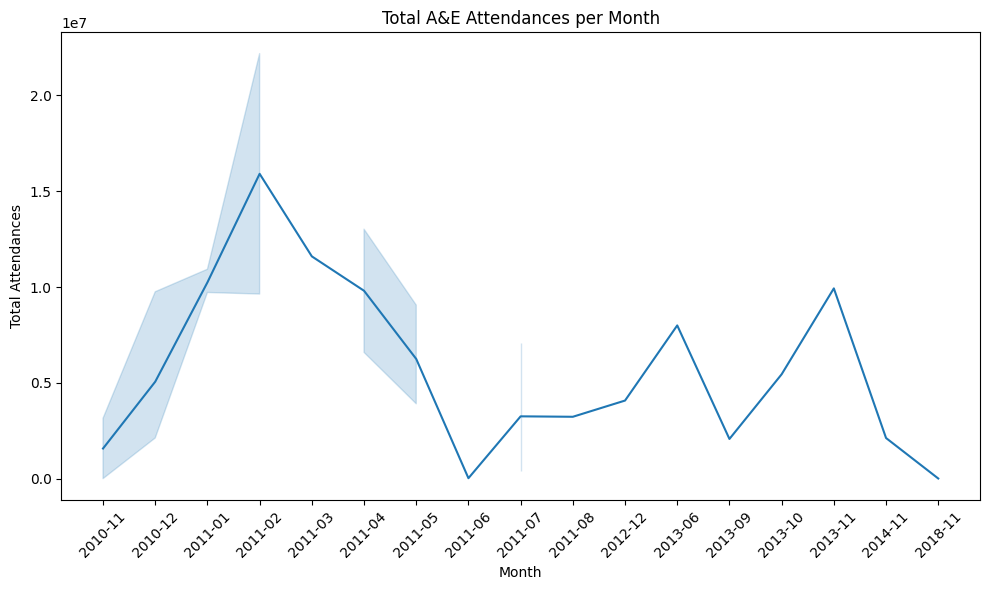

/tmp/ipython-input-2162054939.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


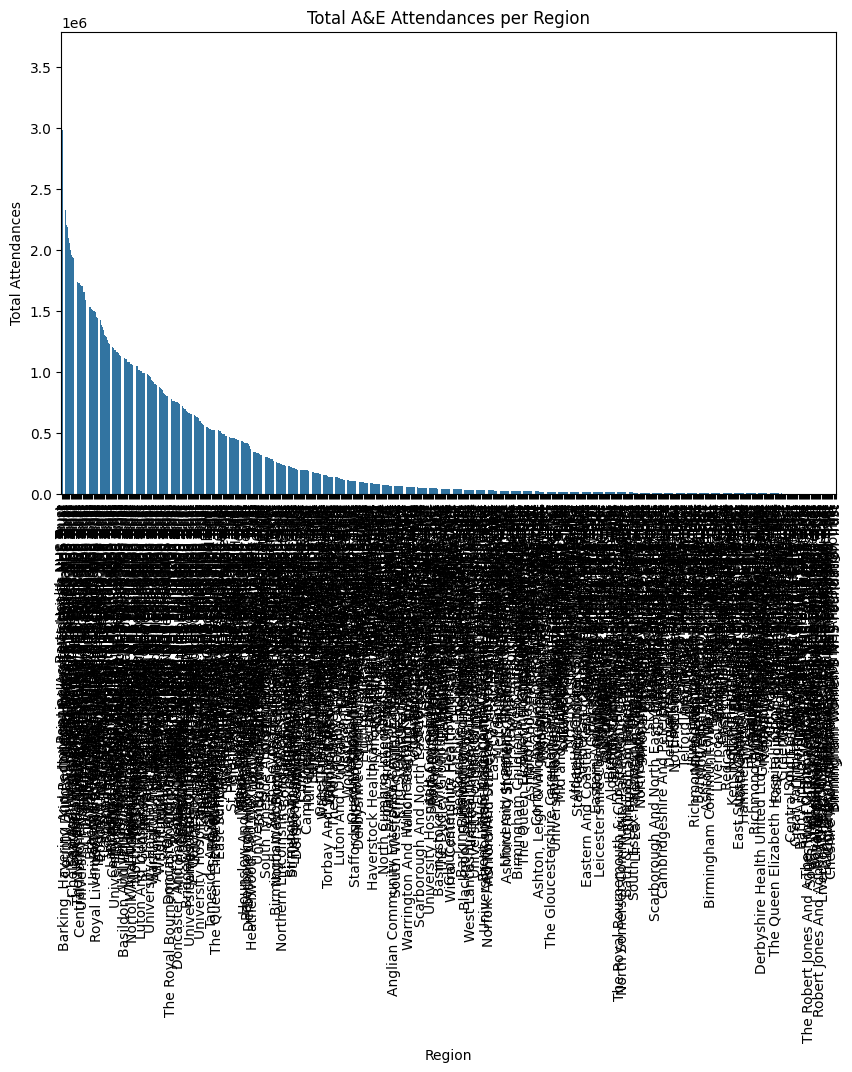

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot total attendances per month
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_monthly, x='month', y='total_attendances')
plt.title('Total A&E Attendances per Month')
plt.xlabel('Month')
plt.ylabel('Total Attendances')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot total attendances per region
plt.figure(figsize=(10, 6))
sns.barplot(data=df_region, x='Name', y='total_attendances')
plt.title('Total A&E Attendances per Region')
plt.xlabel('Region')
plt.ylabel('Total Attendances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [24]:
# Save the filtered data to a CSV file
df_filtered.to_csv('filtered_ae_attendances.csv', index=False)


# README.md

In [ ]:
# A&E Attendances Analysis

## Dataset Overview

This dataset contains monthly data on patients attending Emergency Departments in England, including geographic locations.

## Data Cleaning

- Handled missing values by filling with the median.
- Converted 'date' column to datetime format.
- Removed duplicate rows.

## Exploratory Data Analysis

- **Summary Statistics:** Provided minimum, maximum, and average attendances.
- **Monthly Attendances:** Analyzed total attendances per month.
- **Regional Attendances:** Examined total attendances per region.

## Filtering

- Filtered records with attendances greater than 10,000.
- Filtered records for the 'London' region.

## Visualizations

- Line plot of total attendances per month.
- Bar plot of total attendances per region.
